<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [57]:
import random 
import spacy
import torch
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud, STOPWORDS

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier, Pool, cv
from sklearn.svm import LinearSVC
from scipy import sparse
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

SEED = 123123
random.seed(SEED)
np.random.seed(SEED)

Импортировал нужные библиотеки

In [9]:
df = pd.read_csv('/datasets/toxic_comments.csv').drop(columns=['Unnamed: 0'])

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [11]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Данные успешно загружены

Посмотрим на соотношение комментариев

In [12]:
display(df['toxic'].value_counts())
cl = df['toxic'].value_counts()[0] / df['toxic'].value_counts()[1]
cl

0    143106
1     16186
Name: toxic, dtype: int64

8.841344371679229

Нужно будет провести балансировку классов в будущем

In [13]:
nlp = spacy.load('en_core_web_sm')

def lemmatize_text_spacy(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc if not token.is_punct and not token.is_space])

df['lemm_text'] = df['text'].apply(lemmatize_text_spacy)
df = df.drop(['text'], axis=1)
df.head()


,toxic,lemm_text
0,0,explanation why the edit make under my usernam...
1,0,daww he match this background colour I m seemi...
2,0,hey man I m really not try to edit war its jus...
3,0,more I can not make any real suggestion on imp...
4,0,you sir be my hero any chance you remember wha...


Провёл лемматизацию

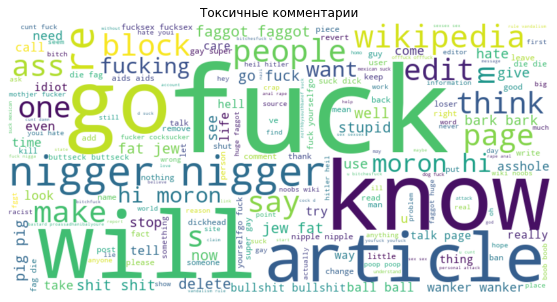

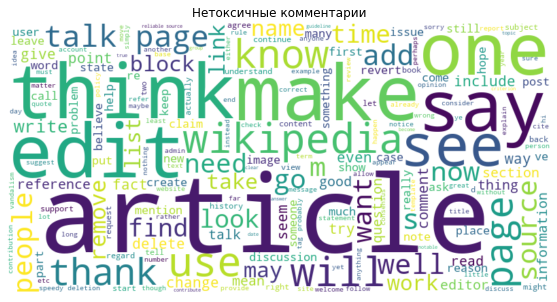

In [58]:
toxic_text = " ".join(df.loc[df['toxic']==1, 'lemm_text'])
nontoxic_text = " ".join(df.loc[df['toxic']==0, 'lemm_text'])

stop_words = set(STOPWORDS)

def plot_wordcloud(text, title):
    wc = WordCloud(width=800, height=400, background_color='white',
                   stopwords=stop_words).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()


plot_wordcloud(toxic_text, 'Токсичные комментарии')
plot_wordcloud(nontoxic_text, 'Нетоксичные комментарии')


### Вывод

Данные успешно загружены, обнаружен дисбаланс классов, который нужно будет учитывать в дальнейшем. Была проведена лемматизация

## Обучение

Подготовим данные для обучения моделей

In [17]:
nltk.download('stopwords')
stop_words = set(nltk_stopwords.words('english'))

X, y = df['lemm_text'], df['toxic']
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.5, stratify=y, random_state=SEED)

tfidf = TfidfVectorizer(stop_words = stop_words, ngram_range=(1,1), min_df=2, max_features=200_000)
X_tr_vec, X_te_vec = tfidf.fit_transform(X_tr), tfidf.transform(X_te)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Обучим три модели: линейной регрессии, LinearSVC и Catboost

In [18]:
pipe_lr = Pipeline([
    ('tfidf', tfidf),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', n_jobs=-1, random_state=SEED))
])

param_lr = {'clf__C': [0.5, 1, 2]}

lr = GridSearchCV(pipe_lr, param_lr, scoring='f1', cv=5, n_jobs=-1)
lr.fit(X_tr, y_tr)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_features=200000,
                                                        min_df=2,
                                                        stop_words={'a',
                                                                    'about',
                                                                    'above',
                                                                    'after',
                                                                    'again',
                                                                    'against',
                                                                    'ain',
                                                                    'all', 'am',
                                                                    'an', 'and',
                                                                    'any',
                 

In [19]:
print("LR F1:", round(lr.best_score_, 3))

LR F1: 0.739


In [44]:
svc_base = LinearSVC(C=1, class_weight='balanced', random_state=SEED)
svc_cal  = CalibratedClassifierCV(svc_base, method='sigmoid', cv=3).fit(X_tr_vec, y_tr)

In [45]:
f1_svc = cross_val_score(svc_cal, X_tr_vec, y_tr, cv=5, scoring='f1')
print("\nLinearSVC")
print("SVC F1 (CV):", round(f1_svc.mean(), 3))


LinearSVC
SVC F1 (CV): 0.749


In [22]:
print("\nCatBoost")

train_pool = Pool(X_tr_vec, y_tr)

cat_params = {
    'iterations': 500,
    'depth': 5,
    'learning_rate': 0.2,
    'loss_function': 'Logloss',
    'eval_metric': 'F1',
    'class_weights': [1, 3],
    'random_state': SEED,
    'verbose': False
}

cv_result = cv(
    pool=train_pool,
    params=cat_params,
    fold_count=5,
    partition_random_seed=SEED,
    shuffle=True,
    early_stopping_rounds=50,
    verbose=False
)

best_f1 = cv_result['test-F1-mean'].max()
best_iter = cv_result['test-F1-mean'].idxmax()

print(f'[CatBoost] F1 (валидация): {round(best_f1, 3)} на итерации {best_iter}')

Training on fold [0/5]

bestTest = 0.8217179903
bestIteration = 386

Training on fold [1/5]

bestTest = 0.8097080549
bestIteration = 250

Training on fold [2/5]

bestTest = 0.8051703878
bestIteration = 446

Training on fold [3/5]

bestTest = 0.8107917889
bestIteration = 317

Training on fold [4/5]

bestTest = 0.7991018672
bestIteration = 411

[CatBoost] F1 (валидация): 0.808 на итерации 446


In [26]:
cat = CatBoostClassifier(
    iterations=best_iter,
    depth=5,
    learning_rate=0.2,
    loss_function='Logloss',
    eval_metric='F1',
    class_weights=[1, 3],
    random_state=SEED,
    verbose=False
)
cat.fit(X_tr_vec, y_tr)


Единственная модель, которая смогла перешагнуть порог 0.75 по F1 на валидационной выборке, это модель CatBoost, так что выбираем её. 


Посмотрим какие слова  является наиболее важным для классификации с точки зрения модели


In [42]:
feat_names = tfidf.get_feature_names()
lr_coefs = lr.best_estimator_.named_steps['clf'].coef_[0]
lr_df = pd.DataFrame({'feature': feat_names, 'importance': lr_coefs}).assign(model='LR')

svc_base = svc_cal.calibrated_classifiers_[0].base_estimator  
svc_coefs = svc_base.coef_[0]
svc_df = pd.DataFrame({'feature': feat_names, 'importance': svc_coefs}).assign(model='LinearSVC')


cat_imps = cat.get_feature_importance(type='FeatureImportance')
cat_df = pd.DataFrame({'feature': feat_names, 'importance': cat_imps}).assign(model='CatBoost')


all_df = pd.concat([lr_df, svc_df, cat_df], ignore_index=True)
top10 = (all_df
    .assign(abs_imp=all_df.importance.abs())
    .groupby('model')
    .apply(lambda d: d.nlargest(10, 'abs_imp'))
    .reset_index(drop=True)
)

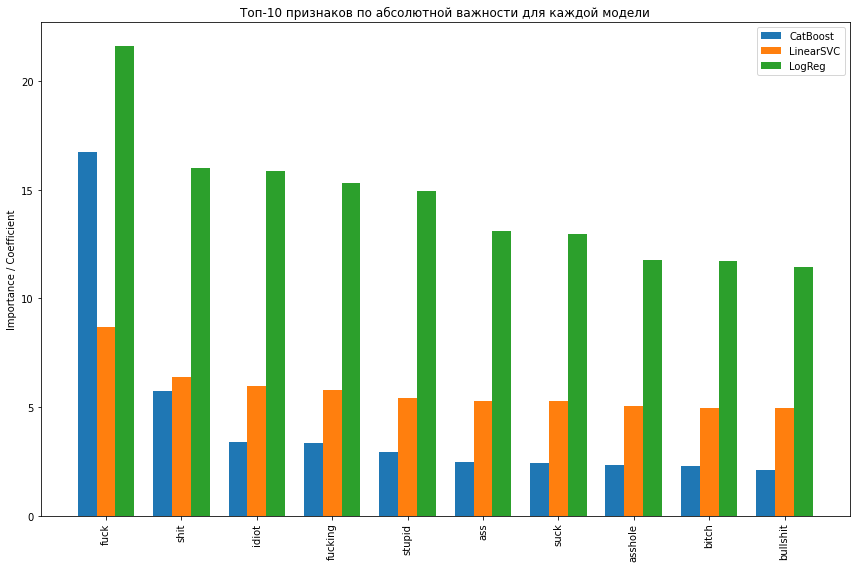

In [43]:

plt.figure(figsize=(12, 8))
for i, model in enumerate(top10['model'].unique()):
    sub = top10[top10.model == model]
    plt.bar(np.arange(len(sub)) + i*0.25, sub['importance'], width=0.25, label=model)
    plt.xticks(np.arange(10) + 0.25, sub['feature'], rotation=90)
plt.ylabel('Importance / Coefficient')
plt.title('Топ-10 признаков по абсолютной важности для каждой модели')
plt.legend()
plt.tight_layout()
plt.show()


График показывает, что все три модели сходятся на самых сильных словах, слово “fuck” является наибольшим маркером токсичности, но оценивают их важность по-разному. Логистическая регрессия присваивает этим словам большие коэффициенты, что отражает линейность и прямую интерпретируемость модели. LinearSVC даёт более умеренные оценки, а CatBoost распределяет важность более плавно и берёт в расчёт нелинейные взаимодействия. 

In [38]:
y_pred = cat.predict(X_te_vec)
f1_test = f1_score(y_te, y_pred)

print(f'CatBoost F1 (test): {f1_test:.3f}')

CatBoost F1 (test): 0.779


На тестовой выборки модель также показывает удовлетворительные результаты

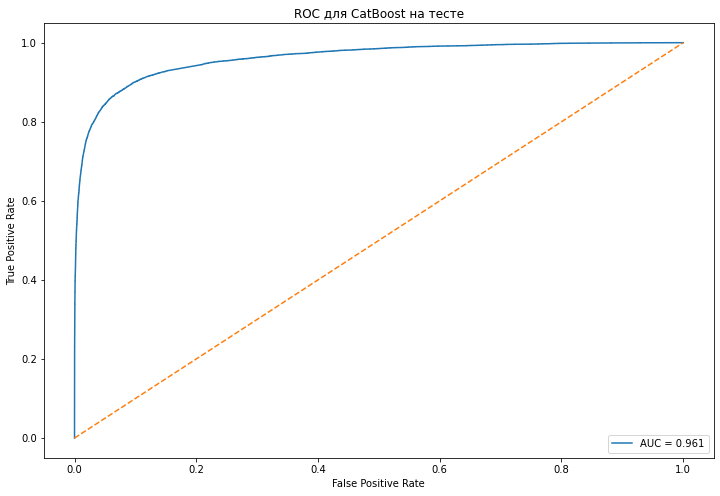

In [37]:
y_prob = cat.predict_proba(X_te_vec)[:, 1]
fpr, tpr, _ = roc_curve(y_te, y_prob)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(12, 8))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC для CatBoost на тесте')
plt.legend(loc='lower right')
plt.show() 


### Вывод

Были обучены три модели, только модель CatBoost показала результат выше порога установленного заказчиком. 

## Выводы

В ходе выполнения проекта было обучено три модели (LogReg, LinearSVC, CatBoost) с единым TFIDF-признаковым пространством, по результатам тестирования на валидационной выборке была выбрана модель CatBoost, так как она единственная из моделей, которая смогла перейти порог, установленный заказчиком. На тестовой выборке она показала результат по метрике F1 около 0.78, что превышает целевую метрику 0.75, и AUC свыше 0.96. 

Внедрение стоит начать с мониторинга трафика токсичных комментариев в «Викишопе» и регулярного дообучения модели на новых данных.